# Week 6 Notes

## 6.1 [Credit risk scoring project](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/01-credit-risk.md)

This week we'll focus on a credit risk scoring model. For example if a customer wants to borrow money from a bank, the bank can decide whether to lend the money or not based on some information. The model predicts a risk that a customer would default on their loan.

The model is trained on historical data on people who got a loan and defaulted or not. The model is a binary classification model, similar to last week's customer churn model.

$$
y_i \in \{0, 1\}
$$

0 means the customer did not default, 1 means the customer did default.


## 6.2 [Data cleaning and preparation](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/02-data-prep.md)


In [1]:
# !wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv

In [2]:
import pandas as pd


df = pd.read_csv("CreditScoring.csv")

First we'll lower case the columns:

In [3]:
df.columns = df.columns.str.lower()

Next, we'll substitute the numerical values to string, such that we know what the different categories are instead of seeing numbers. To this end we use `df.map` which takes in a mapping dictionary as argument:

In [ ]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
 
marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
 
job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}

df.records = df.records.map(records_values)
df.marital = df.marital.map(marital_values)
df.home = df.home.map(home_values)
df.job = df.job.map(job_values)
 
df.head()

In [ ]:
df.describe().round()

`income`, `assets`, and `debt` have very large values. These are actually missing values. We will replace them by `np.nan`:

In [ ]:
import numpy as np

for c in ["income", "assets", "debt"]:
    df.loc[df[c]==99999999, c] = np.nan

df[["income", "assets", "debt"]].max()

We have one sample with unknown status. We will just drop it:

In [ ]:
df.status.value_counts()

In [8]:
df = df[df["status"]!=0].reset_index(drop=True)

Also, we'll change the encoding. `2` means the customer defaulted so it should become `1`:

In [9]:
df.status = (df.status==2).astype(int)

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [ ]:
df_train.head()

Let's define `y`:

In [13]:
y_train = df_train.status.values
y_val = df_val.status.values
y_test = df_test.status.values

Let's drop the target variable from our dataframes:

In [14]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

Now we are ready to train a model.


## 6.3 [Decision trees](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/03-decision-trees.md)


Decision tree consists of conditions based on which an outcome is predicted. See example below. It's a bunch of if-then-else rules.

<img src=decisiontree.png width=600>

This is an example. If we were to write this in code, it would be:

In [15]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] > 6000:
            return "ok"
        else:
            return "default"

Let's use this decision tree on the first record in `df_train`: 

In [ ]:
xi = df_train.iloc[0].to_dict()

assess_risk(xi)

# y_train[0]

Although we encoded a set of rules in the decision tree above, we can also learn the if-then-else rules using sklearn:

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient="records")

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

We will check our roc auc score on the validation dataset:

In [ ]:
val_dicts = df_val.fillna(0).to_dict(orient="records")
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

It's not great. Let's check it for our training dataset:

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]

roc_auc_score(y_train, y_pred)

The AUC score on the training dataset is perfect, whereas on the validation dataset it's poor. Whatever the model learned on the training dataset, does not translate well to unseen data in the validation dataset. This is called **overfitting**.

What happens is that the model creates a rule for each customer in the training dataset. But this pattern is not true in general. Our model is said to have low bias and high variance. Right now we have not restricted the depth of the decision tree. What this means is that it can create as many conditionals as it wants to fit the data. We end up with overly specific rules which are reprenting the individual samples in the training set, rather then representing any general mechanisms. What we can do is to constrain the decision tree depth. This will give us rules that are less specific.

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

We can see that with a `max_depth` of 3, we have better performance on the validation dataset and it is in line with the training dataset as well, suggesting whatever we learned from the training datset, generalizes to unseen data.

We can visualize the rules that our model came up with by visualizing the decision tree:

In [ ]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.feature_names_))

## 6.4 [Decision tree learning algorithm](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/04-decision-tree-learning.md)

How does a decision tree come up with rules? Let's look at this example dataset:

In [ ]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

We will train a decision tree to split based on this data.

In [ ]:
df_example.sort_values("assets")

In [154]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [ ]:
for T in Ts:
    df_right = df_example[df_example.assets > T]
    df_left = df_example[df_example.assets <= T]
    display(df_left)
    display(df_right)
    print(t)

Based on different thresholds, we have various splits. We can for example decide on a rule based on majority. Let's take `T=4000`.

In [ ]:
T = 4000
df_right = df_example[df_example.assets > T]
df_left = df_example[df_example.assets <= T]
display(df_left)
display(df_right)

We can see above that `df_left` mostly has status `default`, whereas `df_right` mostly has status `ok`. Let's take a look at the misclassification rate as a metric:

In [ ]:
(df_right.status != df_right.status.mode()[0]).mean()

In [ ]:
(df_left.status != df_left.status.mode()[0]).mean()

Taking a weighted average of these, yields:

In [ ]:
(len(df_right) * (df_right.status != df_right.status.mode()[0]).mean() + len(df_left) * (df_left.status != df_left.status.mode()[0]).mean()) / len(df_example)

The misclassification rate is a measure of **impurity**.

In [234]:
table = [("T", "decision left", "impurity left", "decision right", "impurity right", "average")]
for T in Ts:
    df_right = df_example[df_example.assets > T]
    df_left = df_example[df_example.assets <= T]
    table.append(
        (T,
        df_left.status.mode()[0],
        (df_left.status != df_left.status.mode()[0]).mean().round(2),
        df_right.status.mode()[0],
        (df_right.status != df_right.status.mode()[0]).mean().round(2),
        ((df_left.status != df_left.status.mode()[0]).mean().round(2)*len(df_left) + (df_right.status != df_right.status.mode()[0]).mean().round(2)*len(df_right))/(len(df_example)),
    )) 
pd.DataFrame(table[1:], columns=table[0])

,T,decision left,impurity left,decision right,impurity right,average
0,500,default,0.0,ok,0.43,0.37625
1,1000,default,0.0,ok,0.43,0.37625
2,2000,default,0.0,ok,0.33,0.24750


The best split is for `T=3000`, since it has the lowest weighted average impurity.

We will now add a second feature:

In [ ]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]

df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

In [ ]:
df_example.sort_values("debt")

In [237]:
thresholds = {
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 1000, 2000],
}

table = [("feature", "T", "decision left", "impurity left", "decision right", "impurity right", "average")]

for feature, Ts in thresholds.items():
    # print(feature)
    for T in Ts:
        # print("#################")
        # print(feature, T)
        
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
        
        # display(df_left)
        # print(df_left.status.value_counts(normalize=True))
        
        # display(df_right)
        # print(df_right.status.value_counts(normalize=True))

        table.append(
            (
                feature,
                T,
                df_left.status.mode()[0],
                (df_left.status != df_left.status.mode()[0]).mean().round(2),
                df_right.status.mode()[0],
                (df_right.status != df_right.status.mode()[0]).mean().round(2),
                ((df_left.status != df_left.status.mode()[0]).mean().round(2)*len(df_left) + (df_right.status != df_right.status.mode()[0]).mean().round(2)*len(df_right))/(len(df_example)),
            )
        ) 
pd.DataFrame(table[1:], columns=table[0])

,feature,T,decision left,impurity left,decision right,impurity right,average
0,assets,0,default,0.00,ok,0.43,0.37625
1,assets,2000,default,0.00,ok,0.33,0.24750
2,assets,3000,default,0.00,ok,0.20,0.12500
3,assets,4000,default,0.25,ok,0.25,0.25000
4,assets,5000,default,0.50,default,0.50,0.50000
5,assets,8000,default,0.43,ok,0.00,0.37625
6,debt,500,ok,0.00,default,0.43,0.37625
7,debt,1000,ok,0.33,default,0.00,0.24750
8,debt,2000,ok,0.43,default,0.00,0.37625


What we can see here is that the feature `assets` with a weighted average of impurity of 12.5% is the best choice.

If we'd have to summarize the decision tree algorithm it's as follows:

```
for f in features:
    find all thresholds for f
        for t in thresholds
            split dataset using f>t
                compute impurity of this split
select condition with lowest impurity
```

We can split recursively. But if we split too much, we risk overfitting to the dataset. We need to know when to stop splitting. There are some stopping criteria:
1. group is already pure
1. decision tree reaches `max_depth`
1. group too small to split


## 6.5 [Decision trees parameter tuning](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/05-decision-tree-tuning.md)


We want to find parameters `max_depth` and `min_samples_leaf` such that AUC is maximized. Let's start by iterating tree depth:

In [251]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print(f"{d:4} -> {auc:.3f}") if d is not None else print(f"{d} -> {auc:.3f}")

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.754
  10 -> 0.712
  15 -> 0.655
  20 -> 0.652
None -> 0.669


The best AUC score is for `max_depth` of 4, 5, and 6. Although 5 is the best, it's a close call. We have a preference for as little model complexity as possible, therefore we would go with 4. However, we have another parameter to iterate over, `min_samples_leaf`:

In [296]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

df_scores = pd.DataFrame(data=scores, columns=["max_depth", "min_samples_leaf", "auc"]).sort_values("auc", ascending=False)

<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

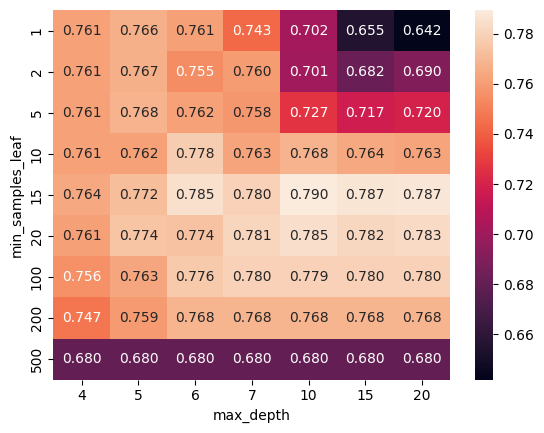

In [297]:
import seaborn as sns


sns.heatmap(df_scores.pivot(index="min_samples_leaf", columns="max_depth", values="auc"), annot=True, fmt=".3f" )


## 6.6 [Ensemble learning and random forest](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/06-random-forest.md)



## 6.7 [Gradient boosting and XGBoost](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/07-boosting.md)



## 6.8 [XGBoost parameter tuning](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/08-xgb-tuning.md)



## 6.9 [Selecting the best model](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/09-final-model.md)



## 6.10 [Summary](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/10-summary.md)



## 6.11 [Explore more](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/11-explore-more.md)



## 6.12 [Homework](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/06-trees/homework.md)
